In [1]:
# imports

# With the exception of the librosa library installed above, all of these modules are 
# either included in the code base or provided by default on Amazon Sagemaker. 

import glob
import pprint
from multiprocessing import Pool
import multiprocessing as mp
import gc
import pickle
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import soundfile as sf
import pandas as pd

In [2]:
from tensorflow import keras

In [3]:
from db import NABat_DB
import db_handler
from spectrogram import Spectrogram
import dataset_generator as ds
import nabat_detector as nd

In [4]:
# Point to a directory containing .wav files organized by species code. 
directory = '../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002'

In [5]:
db = NABat_DB(p="db1")
# Get available information for species.
species = db.query('select * from species;')
sample_classes = ds.get_sample_classes('../Downloads/data/wav')

In [6]:
# Given a model and dataset, query our database to return pulse-level predictions.
def get_predictions_pulse_with_grts_filter(model, draw):
    pulses = db.fastQuery(
        'select count(*) from file f join pulse p on p.file_id = f.id join species s on s.id = f.manual_id where draw = ? and available = 1 and f.grts_id != 0;', (draw,))
    return db.fastQuery("""
    
    with max_conf as (
            select
                p.pulse_id,
                p.confidence
            from
                prediction p
            where 
                p.model_name = ?
            order by 
                p.confidence DESC
        )
        
        select
            f.id,
            f.name,
            s.common_name,
            s.species_code,
            s.id,
            pulse.id, 
            pulse.offset, 
            pulse.time, 
            pulse.amplitude, 
            pulse.frequency,
            max(p.confidence)
        from 
            max_conf
        join
            prediction p on p.pulse_id = max_conf.pulse_id and p.model_name = ?
        join 
            species s on s.id = p.species_id and available = 1
        join 
            pulse on pulse.id = p.pulse_id
        join
            file f on f.id = pulse.file_id and f.grts_id != 0
        join
            species_grts sl on sl.grts_id = f.grts_id and sl.species_id = p.species_id
        where 
            draw = ?
        group by
            p.pulse_id
    """, (model, model, draw)), pulses[0][0]

# Given a model and dataset, query our database to return pulse-level predictions.
def get_predictions_pulse_without_grts_filter(model, draw):
    pulses = db.fastQuery(
        'select count(*) from file f join pulse p on p.file_id = f.id join species s on s.id = f.manual_id where draw = ? and available = 1 and f.grts_id != 0;', (draw,))
    return db.fastQuery("""
    
    with max_conf as (
            select
                p.pulse_id,
                max(p.confidence) as confidence
            from
                prediction p
            where 
                p.model_name = ?
            group by
                p.pulse_id
        )
        
        select
            f.id,
            f.name,
            s.common_name,
            s.species_code,
            s.id,
            pulse.id, 
            pulse.offset, 
            pulse.time, 
            pulse.amplitude, 
            pulse.frequency,
            max_conf.confidence
        from 
            max_conf
        join
            prediction p on p.pulse_id = max_conf.pulse_id and p.confidence = max_conf.confidence and p.model_name = ?
        join 
            species s on s.id = p.species_id and available = 1
        join 
            pulse on pulse.id = p.pulse_id
        join
            file f on f.id = pulse.file_id and f.grts_id != 0
        where 
            draw = ?
    """, (model, model, draw)), pulses[0][0]

In [7]:
db = NABat_DB("db1")
pulses = db.query("Select * from pulse")
pulses_from_nabat_ml = pd.DataFrame(columns=["ID", "File ID", "Pulse peak frequency", "Pulse peak amplitude", "SNR", "Pulse offset", "Pulse peak time", "Window", "Path"])

In [8]:
for pulse in pulses:
    pulses_from_nabat_ml.loc[len(pulses_from_nabat_ml.index)] = (pulse)
pulses_from_nabat_ml

,ID,File ID,Pulse peak frequency,Pulse peak amplitude,SNR,Pulse offset,Pulse peak time,Window,Path
0,70809,1422,15000,24.975430,8.732431,8930,39.25,None,../Downloads/data/images/20210910_030000.WAV/t...
1,70810,1422,12000,24.198666,8.487923,8990,20.25,None,../Downloads/data/images/20210910_030000.WAV/t...
2,70811,1422,6000,21.691101,9.952824,9020,39.75,None,../Downloads/data/images/20210910_030000.WAV/t...
3,70812,1422,15000,25.561653,8.477205,9170,17.50,None,../Downloads/data/images/20210910_030000.WAV/t...
4,70813,1422,11000,23.314695,10.283643,9230,19.50,None,../Downloads/data/images/20210910_030000.WAV/t...
...,...,...,...,...,...,...,...,...,...
2722,73531,1422,26000,21.265675,10.388149,1781000,23.75,None,../Downloads/data/images/20210910_030000.WAV/t...
2723,73532,1422,27000,23.609585,11.359715,1782080,38.00,None,../Downloads/data/images/20210910_030000.WAV/t...
2724,73533,1422,19000,22.663511,7.555955,1785050,31.50,None,../Downloads/data/images/20210910_030000.WAV/t...
2725,73534,1422,15000,30.553703,13.236683,1789970,35.25,None,../Downloads/data/images/20210910_030000.WAV/t...


In [9]:
db = NABat_DB("db1")
predictions_with_grts, pulse_count = get_predictions_pulse_with_grts_filter("1","train")
predictions_without_grts, pulse_count = get_predictions_pulse_without_grts_filter("1","train")
db.conn.close()

In [10]:
len(predictions_with_grts)

2727

In [11]:
db = NABat_DB(p="db1")
nabat_ml_predictions_w_grts = pd.DataFrame(columns=["File ID", "File name", "Species name", "Species code", "Species ID", "Pulse ID", "Pulse offset", "Pulse peak time", "Pulse peak amplitude", "Pulse peak frequency", "Detection confidence"])
for p in predictions_with_grts:
    nabat_ml_predictions_w_grts.loc[len(nabat_ml_predictions_w_grts.index)] = p 
nabat_ml_predictions_w_grts

,File ID,File name,Species name,Species code,Species ID,Pulse ID,Pulse offset,Pulse peak time,Pulse peak amplitude,Pulse peak frequency,Detection confidence
0,1422,20210910_030000.WAV,Western long-eared myotis,MYEV,28,70809,8930,39.25,24.975430,15000,0.086030
1,1422,20210910_030000.WAV,Big brown bat,EPFU,5,70810,8990,20.25,24.198666,12000,0.065972
2,1422,20210910_030000.WAV,Western long-eared myotis,MYEV,28,70811,9020,39.75,21.691101,6000,0.185690
3,1422,20210910_030000.WAV,Western long-eared myotis,MYEV,28,70812,9170,17.50,25.561653,15000,0.221576
4,1422,20210910_030000.WAV,Western small-footed myotis,MYCI,27,70813,9230,19.50,23.314695,11000,0.063562
...,...,...,...,...,...,...,...,...,...,...,...
2722,1422,20210910_030000.WAV,Big brown bat,EPFU,5,73531,1781000,23.75,21.265675,26000,0.152703
2723,1422,20210910_030000.WAV,Big brown bat,EPFU,5,73532,1782080,38.00,23.609585,27000,0.161710
2724,1422,20210910_030000.WAV,Fringed myotis,MYTH,35,73533,1785050,31.50,22.663511,19000,0.128541
2725,1422,20210910_030000.WAV,Hoary bat,LACI,14,73534,1789970,35.25,30.553703,15000,0.055446


In [12]:
nabat_ml_predictions_wout_grts = pd.DataFrame(columns=["File ID", "File name", "Species name", "Species code", "Species ID", "Pulse ID", "Pulse offset", "Pulse peak time", "Pulse peak amplitude", "Pulse peak frequency", "Detection confidence"])
for p in predictions_without_grts:
    nabat_ml_predictions_wout_grts.loc[len(nabat_ml_predictions_wout_grts.index)] = p 
nabat_ml_predictions_wout_grts

,File ID,File name,Species name,Species code,Species ID,Pulse ID,Pulse offset,Pulse peak time,Pulse peak amplitude,Pulse peak frequency,Detection confidence
0,1422,20210910_030000.WAV,Western long-eared myotis,MYEV,28,70809,8930,39.25,24.975430,15000,0.086030
1,1422,20210910_030000.WAV,Big brown bat,EPFU,5,70810,8990,20.25,24.198666,12000,0.065972
2,1422,20210910_030000.WAV,Western long-eared myotis,MYEV,28,70811,9020,39.75,21.691101,6000,0.185690
3,1422,20210910_030000.WAV,Western long-eared myotis,MYEV,28,70812,9170,17.50,25.561653,15000,0.221576
4,1422,20210910_030000.WAV,Western small-footed myotis,MYCI,27,70813,9230,19.50,23.314695,11000,0.063562
...,...,...,...,...,...,...,...,...,...,...,...
2722,1422,20210910_030000.WAV,Northern yellow bat,LAIN,16,73531,1781000,23.75,21.265675,26000,0.209917
2723,1422,20210910_030000.WAV,Northern yellow bat,LAIN,16,73532,1782080,38.00,23.609585,27000,0.205166
2724,1422,20210910_030000.WAV,Fringed myotis,MYTH,35,73533,1785050,31.50,22.663511,19000,0.128541
2725,1422,20210910_030000.WAV,Hoary bat,LACI,14,73534,1789970,35.25,30.553703,15000,0.055446


In [13]:
nabat_ml_predictions_w_grts.loc[nabat_ml_predictions_w_grts["Species code"] == "LACI"]

,File ID,File name,Species name,Species code,Species ID,Pulse ID,Pulse offset,Pulse peak time,Pulse peak amplitude,Pulse peak frequency,Detection confidence
6,1422,20210910_030000.WAV,Hoary bat,LACI,14,70815,13910,29.50,21.440022,18000,0.075523
15,1422,20210910_030000.WAV,Hoary bat,LACI,14,70824,30380,13.00,24.895599,15000,0.063162
20,1422,20210910_030000.WAV,Hoary bat,LACI,14,70829,48560,28.00,21.650242,14000,0.058490
24,1422,20210910_030000.WAV,Hoary bat,LACI,14,70833,64910,15.75,21.137209,17000,0.070279
26,1422,20210910_030000.WAV,Hoary bat,LACI,14,70835,71840,23.25,23.544226,15000,0.059058
...,...,...,...,...,...,...,...,...,...,...,...
2657,1422,20210910_030000.WAV,Hoary bat,LACI,14,73466,1757690,24.25,22.893394,25000,0.130607
2658,1422,20210910_030000.WAV,Hoary bat,LACI,14,73467,1759850,37.75,21.610214,24000,0.106098
2659,1422,20210910_030000.WAV,Hoary bat,LACI,14,73468,1760330,16.75,26.648106,25000,0.101088
2713,1422,20210910_030000.WAV,Hoary bat,LACI,14,73522,1778210,16.75,29.442436,13000,0.053980


In [14]:
batdetect2_predictions = pd.read_csv('../bat-detector-msds/output_dir/recover-20210912/Foliage/bd2_20210910_030000.csv')
batdetect2_predictions

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name
0,246.9325,246.9418,28046.0,37602.0,Echolocation,Eptesicus serotinus,0.402,0.549,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
1,247.2165,247.2264,28046.0,38133.0,Echolocation,Eptesicus serotinus,0.415,0.573,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
2,247.3525,247.3627,28046.0,38892.0,Echolocation,Eptesicus serotinus,0.422,0.555,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
3,247.4715,247.4794,27187.0,42404.0,Echolocation,Eptesicus serotinus,0.546,0.763,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
4,247.5905,247.6001,28046.0,37383.0,Echolocation,Eptesicus serotinus,0.376,0.530,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206,1781.4465,1781.4565,25468.0,32664.0,Echolocation,Nyctalus leisleri,0.273,0.584,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
3207,1781.5785,1781.5891,26328.0,32298.0,Echolocation,Nyctalus leisleri,0.328,0.577,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
3208,1781.9385,1781.9477,26328.0,34069.0,Echolocation,Eptesicus serotinus,0.294,0.614,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
3209,1782.0615,1782.0702,25468.0,34393.0,Echolocation,Eptesicus serotinus,0.393,0.600,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage


In [15]:
input_files = glob.glob('{}/*.WAV'.format(directory), recursive=True)
key_times = [247, 757, 762, 777, 955, 1155, 1440, 1615]

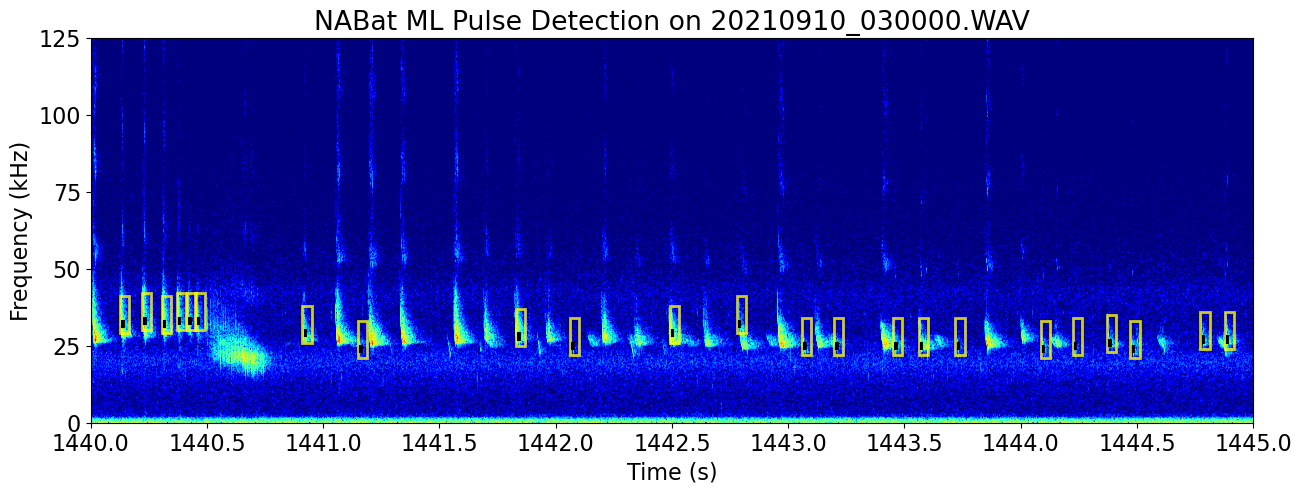

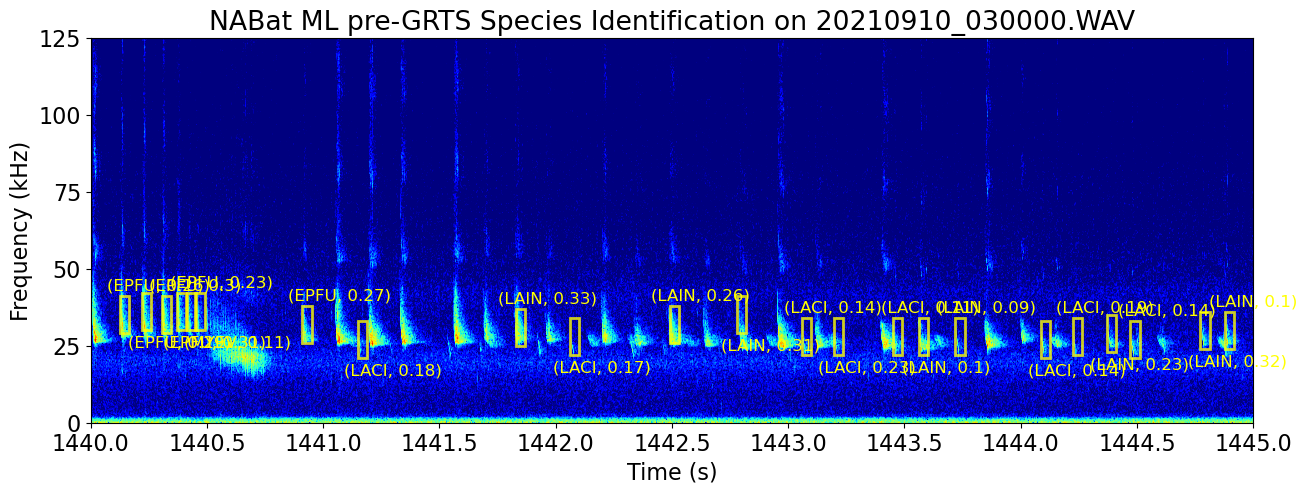

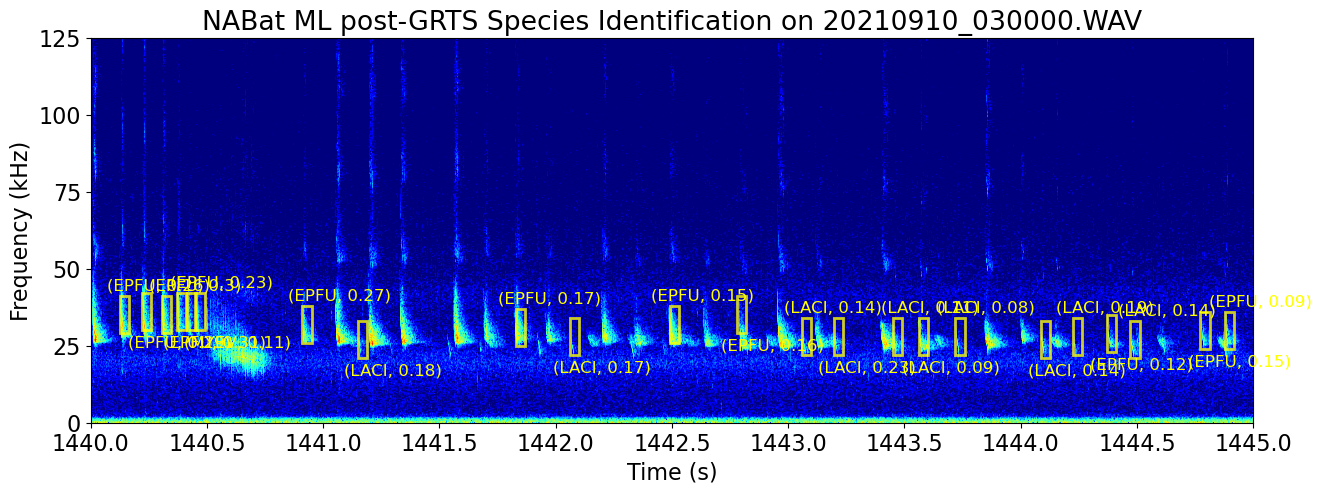

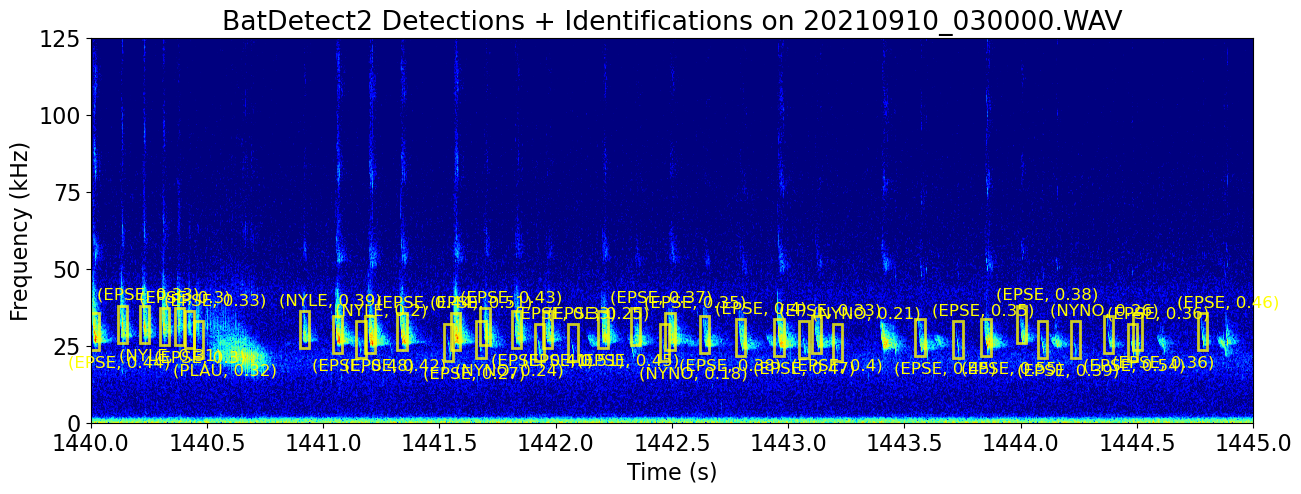

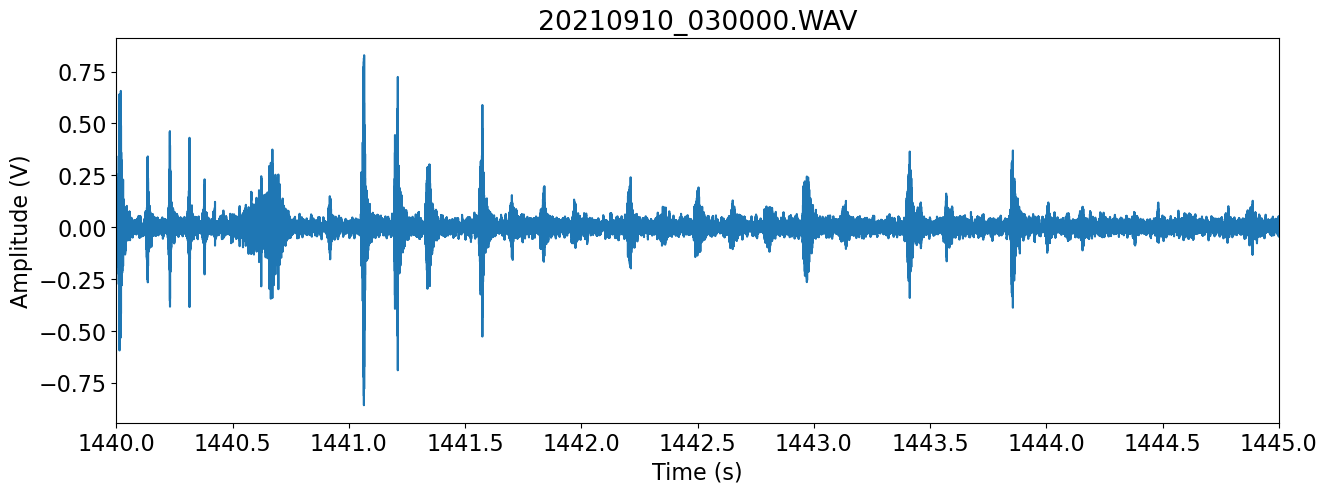

In [21]:
audio_file = sf.SoundFile(input_files[0])
fs = audio_file.samplerate
start = key_times[6]
duration = 5
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB
nabat_ml_predictions = pulses_from_nabat_ml
plot_dets = nabat_ml_predictions.loc[np.logical_and(nabat_ml_predictions['Pulse offset'] > start*1000, nabat_ml_predictions['Pulse offset'] <= (start+duration)*1000)]


plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})
plt.title("NABat ML Pulse Detection on 20210910_030000.WAV")
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)

ax = plt.gca()
for i, row in plot_dets.iterrows():
    rect = patches.Rectangle((((row['Pulse offset'] + row['Pulse peak time'])/1000 - start - 0.06)*(fs/2), (row['Pulse peak frequency']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)
    rect = patches.Rectangle((((row['Pulse offset']-50 + row['Pulse peak time'])/1000 - start)*(fs/2), row['Pulse peak frequency']/(fs/2)), 
                    0.006*(fs/2), 2000/(fs/2), linewidth=1.5, edgecolor='k', facecolor='red')
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")


nabat_ml_predictions = nabat_ml_predictions_wout_grts
plot_dets = nabat_ml_predictions.loc[np.logical_and(nabat_ml_predictions['Pulse offset'] > start*1000, nabat_ml_predictions['Pulse offset'] <= (start+duration)*1000)]

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})
plt.title("NABat ML pre-GRTS Species Identification on 20210910_030000.WAV")
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)

ax = plt.gca()
for i, row in plot_dets.iterrows():
    rect = patches.Rectangle((((row['Pulse offset']-50 + row['Pulse peak time'])/1000 - start - 0.01)*(fs/2), (row['Pulse peak frequency']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)

    if np.mod(i, 2) == 0:
        plt.text(x=(row['Pulse offset']/1000 - start - 0.1)*(fs/2), y=(row['Pulse peak frequency']+12000)/(fs/2), s=f"({row['Species code']}, {round(row['Detection confidence'], 2)})", color='yellow', fontsize=12)
    if np.mod(i, 2) == 1:
        plt.text(x=(row['Pulse offset']/1000 - start - 0.1)*(fs/2), y=(row['Pulse peak frequency']-7500)/(fs/2), s=f"({row['Species code']}, {round(row['Detection confidence'], 2)})", color='yellow', fontsize=12)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")

nabat_ml_predictions = nabat_ml_predictions_w_grts
plot_dets = nabat_ml_predictions.loc[np.logical_and(nabat_ml_predictions['Pulse offset'] > start*1000, nabat_ml_predictions['Pulse offset'] <= (start+duration)*1000)]


plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})
plt.title("NABat ML post-GRTS Species Identification on 20210910_030000.WAV")
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)

ax = plt.gca()
for i, row in plot_dets.iterrows():
    rect = patches.Rectangle((((row['Pulse offset']-50 + row['Pulse peak time'])/1000 - start - 0.01)*(fs/2), (row['Pulse peak frequency']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)

    if np.mod(i, 2) == 0:
        plt.text(x=(row['Pulse offset']/1000 - start - 0.1)*(fs/2), y=(row['Pulse peak frequency']+12000)/(fs/2), s=f"({row['Species code']}, {round(row['Detection confidence'], 2)})", color='yellow', fontsize=12)
    if np.mod(i, 2) == 1:
        plt.text(x=(row['Pulse offset']/1000 - start - 0.1)*(fs/2), y=(row['Pulse peak frequency']-7500)/(fs/2), s=f"({row['Species code']}, {round(row['Detection confidence'], 2)})", color='yellow', fontsize=12)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")

plt.figure(figsize=(15, 5))
plt.title("BatDetect2 Detections + Identifications on 20210910_030000.WAV")
plt.rcParams.update({'font.size': 16})
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

ax = plt.gca()
for i, row in plot_dets.iterrows():
    rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    
    if np.mod(i, 2) == 0:
        plt.text(x=(row['start_time'] - start - 0.1)*(fs/2), y=(row['low_freq']+12000)/(fs/2), s=f"({row['class'].upper().split()[0][:2]}{row['class'].upper().split()[1][:2]}, {round(row['class_prob'], 2)})", color='yellow', fontsize=12)
    if np.mod(i, 2) == 1:
        plt.text(x=(row['start_time'] - start - 0.1)*(fs/2), y=(row['low_freq']-7500)/(fs/2), s=f"({row['class'].upper().split()[0][:2]}{row['class'].upper().split()[1][:2]}, {round(row['class_prob'], 2)})", color='yellow', fontsize=12)

    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")

plt.figure(figsize=(15, 5))
plt.title("20210910_030000.WAV")
plt.plot(audio_seg)
plt.xlim(0, duration*fs)
plt.xticks(ticks=np.linspace(0, duration*fs, 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Amplitude (V)")
plt.xlabel("Time (s)")

plt.show()